In [1]:
import numpy as np
import matplotlib.pyplot as plt
import scipy

from mpl_toolkits.axes_grid1.axes_divider import make_axes_locatable

# Random gaussian field creation

## Code

In [2]:
map_size = 2 #arcminutes
pixel_size = 1/2 #arcseconds

pixel_number = map_size*(60/pixel_size)

x = np.linspace(-0.5*map_size, 0.5*map_size, int(pixel_number))
y = np.linspace(-0.5*map_size, 0.5*map_size, int(pixel_number))
X, Y = np.meshgrid(x, y)
R = np.sqrt(X**2 + Y**2)

l = np.arange(30000, dtype=float)
const = 10
index = -0.7

spectrum=const*(l**index)
spectrum[0] = 0

/tmp/ipykernel_12563/319828132.py:15: RuntimeWarning: divide by zero encountered in power
  spectrum=const*(l**index)


In [3]:
fs_scale_factor = np.pi/(pixel_size/60 * np.pi/180)
R_fs = R*fs_scale_factor
print(R_fs.astype(int))

spectrum_map = np.zeros(int(R_fs.max())+1)

spectrum_map[0:spectrum.size] = spectrum

spectrum_map_confined = spectrum_map[(R_fs).astype(int)]
print(spectrum_map.shape)
print(spectrum_map_confined.shape)
print(240*240)

[[30547 30419 30292 ... 30292 30419 30547]
 [30419 30291 30163 ... 30163 30291 30419]
 [30292 30163 30035 ... 30035 30163 30292]
 ...
 [30292 30163 30035 ... 30035 30163 30292]
 [30419 30291 30163 ... 30163 30291 30419]
 [30547 30419 30292 ... 30292 30419 30547]]
(30548,)
(240, 240)
57600


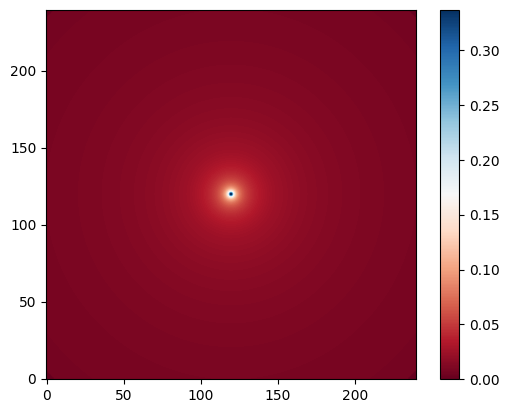

In [4]:
im = plt.imshow(spectrum_map_confined, interpolation='bilinear', origin='lower', cmap='RdBu')
#im.set_clim(0,spectrum_map_confined.max()/4)
cbar = plt.colorbar()
plt.show()

In [5]:
random_noise_2d = np.random.normal(0, 1, (int(pixel_number), int(pixel_number)))
random_noise_2d_fs = np.fft.fft2(random_noise_2d)

signal_map_fs = spectrum_map_confined*random_noise_2d_fs

signal_map = np.fft.ifft2(np.fft.fftshift(signal_map_fs))

In [6]:
#signal_map = np.fft.ifft2(signal_map_fs)
signal_map = signal_map / fs_scale_factor
signal_map = np.real(signal_map)

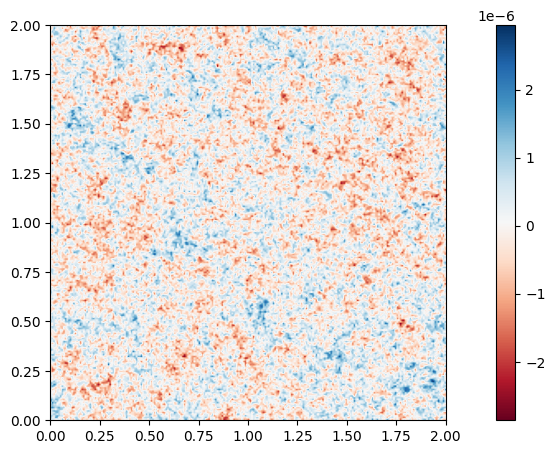

In [83]:
im = plt.imshow(signal_map, origin='lower', interpolation='bilinear', cmap='RdBu')
im.set_clim()
X_width = pixel_number*pixel_size/60.  # horizontal map width in degrees
Y_width = pixel_number*pixel_size/60.  # vertical map width in degrees

plt.gcf().set_size_inches(6,6)
ax=plt.gca()
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad=0.5)
cbar = plt.colorbar(im, cax=cax)
im.set_extent([0,X_width,0,Y_width])
plt.show()

In [72]:
signal_map.max()

np.float64(2.9528164047595824e-06)

## Class

In [17]:
class missing_variable_error(Exception):
    """raised when necessary variables are not given"""
    def __init__(self, variable_name: str):
        super().__init__(f"{variable_name} has not been specified. Please provide a value.")

class map_maker():
    def __init__(self, map_size: int = None, pixel_size: float = None, pixel_number: int = None, l_degrees: int = None, const: float = 1, index: float = -1):
        ## external variables
        self.map_size = map_size
        self.pixel_size = pixel_size
        self.pixel_number = pixel_number
        self.l_degrees = l_degrees
        self.const = const
        self.index = index
        ## internal variables
        self.spectrum = None                       # unless loaded in
        self.R = None
        self.R_check = False
        self.fs_scale_factor = None
        self.R_fs = None
        self.R_fs_check = False
        self.random_noise_2d = None
        self.random_noise_2d_fs = None
        ## output variables
        self.grf_fs = None
        self.grf = None
        self.rms = None

    def set_map_variables(self, map_size = None, pixel_size = None, pixel_number = None) -> bool:
        if map_size is not None:
            self.map_size = map_size
        if pixel_size is not None:
            self.pixel_size = pixel_size
        if pixel_number is not None:
            self.pixel_number = pixel_number
        else:
            self.pixel_number = self.map_size*(60/self.pixel_size)
        if not all((self.map_size, self.pixel_size, self.pixel_number)):
            print("!!!!!!!!!!!There are still missing map_variables.")
            return False
        else:
            print("Full set of map variables defined.")
            return True

    def make_map_coordinates(self, map_size = None, pixel_size = None, pixel_number = None):
        
        if any((map_size, pixel_size, pixel_number)) or self.pixel_number is None:
            self.set_map_variables(map_size, pixel_size, pixel_number)
        x = np.linspace(-0.5*self.map_size, 0.5*self.map_size, int(self.pixel_number))
        y = np.linspace(-0.5*self.map_size, 0.5*self.map_size, int(self.pixel_number))
        X, Y = np.meshgrid(x, y, sparse=True)           ## TODO: check if sparse works correctly
        self.R = np.sqrt(X**2 + Y**2)
        self.R_check = True
        print("map made.")

        return None
    
    def _compute_fourierSpace_scaler(self) -> float:
        if self.pixel_size is None:
            raise missing_variable_error("pixel_size")
        fs_scale_factor = np.pi/(self.pixel_size/60 * np.pi/180)
        self.fs_scale_factor = fs_scale_factor
        return fs_scale_factor
    
    def _R_fourierSpace_mapping(self) -> list[float]:
        scale = self._compute_fourierSpace_scaler()
        R_fs = self.R*scale
        self.R_fs = R_fs
        self.R_fs_check = True
        return R_fs
    
    def set_spectrum_variables(self, l_degrees: int = None, const:float = None, index: float = None) -> bool:
        if l_degrees is not None:
            print(l_degrees)
            self.l_degrees = l_degrees
            print(self.l_degrees)
        if const is not None:
            self.const = const
        if index is not None:
            self.index = index
        if not any((self.map_size, self.pixel_size, self.pixel_number)):
            print("!!!!!!!!!!!There are still missing variables for the spectrum (power-law).")
            return False
        else:
            print("Full set of variables for the spectrum (power-law) defined.")
            return True

    def make_spectrum(self, const: float = None, l_degrees: int = None, index: float = None) -> None:
            
        self.set_spectrum_variables(const, l_degrees, index)
        l = np.arange(self.l_degrees, dtype=float)

        spectrum=self.const*(l**self.index)
        spectrum[0] = 0
        self.spectrum = spectrum

        return None
    
    def load_spectrum(self, path: str) -> None:
        """ 
            Spectrum different than a power law? Here you go...
            TODO: All of it ...
        """
        return None
    
    def make_spectrum_map(self, spectrum_path: str = None, const: float = None, l_degrees: int = None, index: float = None) -> None:
        """ 
            Creates a map of the spectrum (Inside Fourier Space) as well as a cut version leaving out areas of null values.
            TODO: add option to intervene in scale

        """

        if spectrum_path is not None:
            self.load_spectrum(self, spectrum_path)
        elif any((const, l_degrees, index)) or self.spectrum is None:
            self.make_spectrum(const, l_degrees, index)

        if self.R_fs is None:
            self._R_fourierSpace_mapping()

        spectrum_map_complete = np.zeros(int(self.R_fs.max())+1)
        spectrum_map_complete[0:self.spectrum.size] = self.spectrum

        if self.R_fs is None:
            raise missing_variable_error("R_fs")

        spectrum_map_confined = spectrum_map_complete[(self.R_fs).astype(int)]
        self.spectrum_map_complete = spectrum_map_complete
        self.spectrum_map_confined = spectrum_map_confined
        return None

    def _make_random_noise(self, N: int = None) -> None:
        if N is not None:
            self.pixel_number = N
        self.random_noise_2d = np.random.normal(0, 1, (int(self.pixel_number), int(self.pixel_number)))
        self.random_noise_2d_fs = np.fft.fft2(self.random_noise_2d)
        return None

    def make_gaussian_random_field(self) -> list[float]:
        
        if not self.R_check:
            self.make_map_coordinates()
        if not self.R_fs_check:  
            self._R_fourierSpace_mapping()
        self.make_spectrum_map()
        self._make_random_noise()

        self.grf_fs = self.spectrum_map_confined*self.random_noise_2d_fs              ## gaussian-random-field in Fourier-Space

        self.grf = np.fft.ifft2(np.fft.fftshift(self.grf_fs))           ## gaussian-random-field after inverse fft2

        self.grf_real = np.real(np.fft.ifft2(np.fft.fftshift(self.grf_fs))) 
        
        return self.grf_fs, self.grf, self.grf_real
    
    def plot_gaussian_random_field(self) -> None:
        im = plt.imshow(self.grf_real, origin='lower', interpolation='bilinear', cmap='RdBu')
        im.set_clim()

        plt.xlabel(r"$\theta_x$[arcmin]")
        plt.ylabel(r"$\theta_y$[arcmin]")

        cbar = plt.colorbar(im)
        cbar.set_label("T [K]")   # label for the scale
        return None
    
    def rms_estimation(self) -> float:
        self.rms = np.sqrt(np.mean(self.grf_real**2))
        return self.rms

## Test

Full set of map variables defined.
map made.
Full set of variables for the spectrum (power-law) defined.


/tmp/ipykernel_5813/2613377579.py:93: RuntimeWarning: divide by zero encountered in reciprocal
  spectrum=self.const*(l**self.index)


0.0014127398702623196


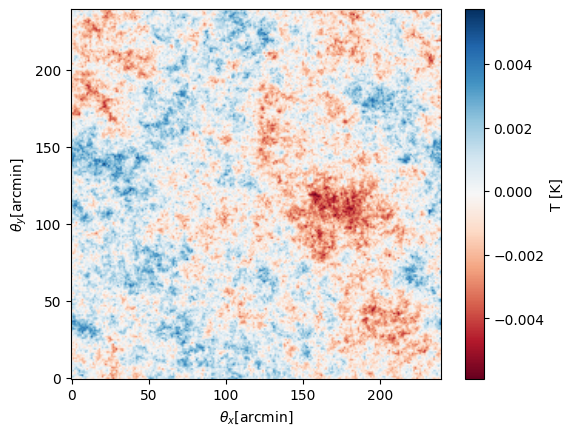

In [21]:
test1 = map_maker(map_size=2, pixel_size=0.5, l_degrees=30000, const=10, index=-1)
test1_map_fs, test1_map, test1_map_real = test1.make_gaussian_random_field()
test1.plot_gaussian_random_field()
print(test1.rms_estimation())

# lensing

## code

In [109]:
class lensing():
    def __init__(self, map_size: float = None, pixel_size: float = None, pixel_number: int = None, dec_shift = 0, asc_shift = 0, pre_lens_map: list[list[float]] = None, poly_degree = 2):
        self.map_size = map_size
        self.pixel_size = pixel_size
        self.pixel_number = pixel_number
        self.dec_shift = dec_shift
        self.asc_shift = asc_shift
        self.pre_lens_map = pre_lens_map
        self.l_total = poly_degree
        ## internal vatiables
        self.pos_map = None
        self.pos_map_fs = None
        self.lensing_map = None
        ## output
        self.post_lensing_map = None

    
    def set_NFW_variables(self) -> None:
        return None
    
    def make_NFW_profile(self) -> None:
        return None
    
    def set_map_parameters(self, map_size: float = None, pixel_size: float = None, pixel_number: int = None) -> None:
        if map_size is not None:
            self.map_size = map_size
        if pixel_size is not None:
            self.pixel_size = pixel_size
        if pixel_number is not None:
            self.pixel_number = pixel_number
        else:
            self.pixel_number = self.map_size*(60/self.pixel_size)
        if not all((self.map_size, self.pixel_size, self.pixel_number)):
            print("!!!!!!!!!!!There are still missing map_variables.")
            return False
        else:
            print("Full set of map variables defined.")
            return True
    
    def make_lensing_map():
        return None
    
    def set_pre_lens_map(self, map: list[list[float]]) -> None:
        self.pre_lens_map = map
        return None
    
    def copy_map_parameters(self):
        if not (self.pre_lens_map).any():
            print("!!!!!!!!!!!!!!!!! Please first provide a pre lens map.")
        elif ((self.pre_lens_map).shape[0] != (self.pre_lens_map).shape[1]):
            print("!!!!!!!!!!Please provide squared map.")
        else:
            self.pixel_number = (self.pre_lens_map).shape[0]
            self.pixel_size = 1                                     ######### Temporary solution
            self.map_size = self.pixel_number                       ######### Temporary solution
            print("Map parameters: map_size = " + str(self.map_size) + ", pixel_size = " + str(self.pixel_size) + ", pixel_number = " + str(self.pixel_number) + ".")
        return None
    
    # def _make_background_map(self) -> list[list[list[float]], float]:
    #     mean = np.mean(self.pre_lens_map)
    #     bg_map = np.ones((self.pixel_number, self.pixel_number))*mean
    #     self.background_map = bg_map
    #     return bg_map, mean
    
    def _make_pos_map(self, shift_dec = 0, shift_asc = 0):
        # real_space
        dec, asc = np.linspace(-self.map_size/2, self.map_size/2, self.pixel_number), np.linspace(-self.map_size/2, self.map_size/2, self.pixel_number)
        pos_map = np.meshgrid(dec, asc)
        ## Necessary because tuples can only be read (not modified)
        pos_map_obj_1, pos_map_obj_2 = pos_map 
        pos_map_obj_1 += shift_dec
        pos_map_obj_2 += shift_asc
        self.pos_map =  pos_map_obj_1, pos_map_obj_2

        # fourier_space
        x, y = 2*np.pi*np.fft.fftfreq(self.pixel_number, (np.pi*180)*self.pixel_size/60), 2*np.pi*np.fft.fftfreq(self.pixel_number, (np.pi*180)*self.pixel_size/60)  ## pixel_size given in seconds
        self.pos_map_fs = np.meshgrid(x, y)
        return None
    
    def _make_pos_map_test(self, shift_dec = 0, shift_asc = 0) -> None:
        # real_space
        dec, asc = np.linspace(-self.map_size/2, self.map_size/2, self.pixel_number), np.linspace(-self.map_size/2, self.map_size/2, self.pixel_number)
        pos_map = np.meshgrid(dec, asc)
        ## Necessary because tuples can only be read (not modified)
        pos_map_obj_1, pos_map_obj_2 = pos_map 
        pos_map_obj_1 += shift_dec
        pos_map_obj_2 += shift_asc
        self.pos_map =  pos_map_obj_1, pos_map_obj_2

        # fourier_space
        self.pos_map_fs = np.fft.fft2(self.pos_map)

        return None
    
    def apply_lensing(self, pre_lens_map = None, shift_dec = 0, shift_asc = 0):
        if pre_lens_map:
            self.pre_lens_map = pre_lens_map

        self._make_pos_map(shift_dec, shift_asc)
        dec_pos, asc_pos = self.pos_map
        post_lensing_dec_pos, post_lensing_asc_pos = dec_pos + self.lensing_map[0], asc_pos + self.lensing_map[1]
        interpolate = scipy.interpolate.RectBivariateSpline(asc_pos[:,0], dec_pos[0,:], self.pre_lens_map, kx = self.l_total, ky = self.l_total)
        self.post_lensing_map  = interpolate.ev(post_lensing_asc_pos.flatten(), post_lensing_dec_pos.flatten()).reshape([len(asc_pos), len(dec_pos)]) 

        return None
    
    def get_lensed_map(self) -> list[list[float]]:
        return self.post_lensing_map
    
    def plot_lensed_map():
        return None

In [110]:
cmb = np.array([[0, 1, 1], [1, 1, 0], [0, 0, 1]])
cmb_lensing = np.array([[3, 0, -3], [3, 0, -3], [3, 0, -3]]), np.array([[3, 3, 3], [0, 0, 0], [-3, -3, -3]])
lensTest1 = lensing(pre_lens_map=cmb)
lensTest1.lensing_map = cmb_lensing

#lensTest1.set_map_parameters(10, 1, 10)
lensTest1.copy_map_parameters()

Map parameters: map_size = 3, pixel_size = 1, pixel_number = 3.


In [112]:
lensTest1._make_pos_map()
lensTest1.apply_lensing()
lensTest1.get_lensed_map()

array([[1., 0., 0.],
       [0., 1., 1.],
       [1., 1., 0.]])

## class

# Other

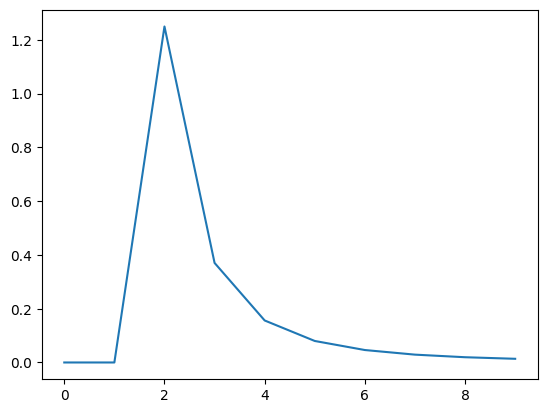

In [15]:
plt.plot(l, spectrum)

In [12]:
3**(-3)*10

0.37037037037037035

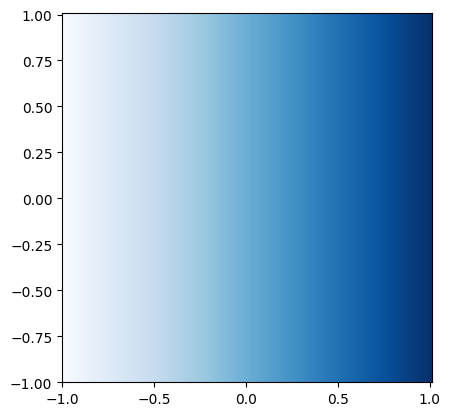

In [9]:
plt.imshow(X, cmap = 'Blues', extent=[min(x),max(x)+0.01,min(x),max(x)+0.01])

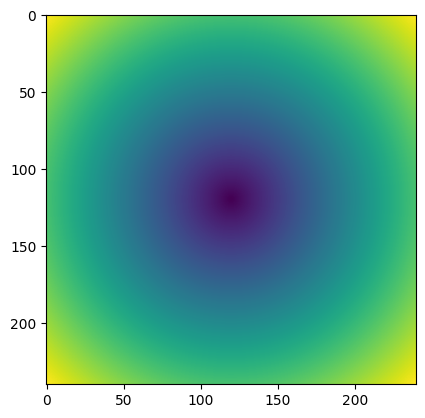

In [15]:
plt.imshow(R)

In [11]:
X

array([[-1.       , -0.9916318, -0.9832636, ...,  0.9832636,  0.9916318,
         1.       ],
       [-1.       , -0.9916318, -0.9832636, ...,  0.9832636,  0.9916318,
         1.       ],
       [-1.       , -0.9916318, -0.9832636, ...,  0.9832636,  0.9916318,
         1.       ],
       ...,
       [-1.       , -0.9916318, -0.9832636, ...,  0.9832636,  0.9916318,
         1.       ],
       [-1.       , -0.9916318, -0.9832636, ...,  0.9832636,  0.9916318,
         1.       ],
       [-1.       , -0.9916318, -0.9832636, ...,  0.9832636,  0.9916318,
         1.       ]])

In [13]:
Y

array([[-1.       , -1.       , -1.       , ..., -1.       , -1.       ,
        -1.       ],
       [-0.9916318, -0.9916318, -0.9916318, ..., -0.9916318, -0.9916318,
        -0.9916318],
       [-0.9832636, -0.9832636, -0.9832636, ..., -0.9832636, -0.9832636,
        -0.9832636],
       ...,
       [ 0.9832636,  0.9832636,  0.9832636, ...,  0.9832636,  0.9832636,
         0.9832636],
       [ 0.9916318,  0.9916318,  0.9916318, ...,  0.9916318,  0.9916318,
         0.9916318],
       [ 1.       ,  1.       ,  1.       , ...,  1.       ,  1.       ,
         1.       ]])